In [46]:
#introducing libraries
!pip install numpy scipy pandas>1.0 matplotlib lmfit colour

In [47]:
#calling up libraries
from datetime import datetime
import pandas as pd
import numpy as np
import scipy
import scipy.integrate as integrate
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.ticker import StrMethodFormatter
from matplotlib import cm

In [48]:
#import CSV data from drive
from google.colab import drive
import glob
import os
drive.mount('drive', force_remount=True)
folder = "/content/drive/MyDrive/NP JV sweeps"
all_files_AV = glob.glob(os.path.join(folder, '*.csv'))
AV_li = {}
for filename in all_files_AV:
  subn = int(filename.split(sep='-')[1].split(sep='.')[0])
  print(subn)
  name = subn
  #isolates name from file and drops last 3 rows
  df = pd.read_csv(filename, sep = ',' , header = 1, nrows = 122, index_col='V')
  df.rename(columns={'mA/cm^2': 'mA/cm^2.0'}, inplace=True)
  AV_li[name] = df
AV_li

Mounted at drive
2
3
8
11
13
1


{1:       mA/cm^2.0  mA/cm^2.1  mA/cm^2.2  ...  mA/cm^2.5  mA/cm^2.6  mA/cm^2.7
 V                                      ...                                 
 0.00  -1.780130  -1.615220  -1.479920  ...  -1.446090  -1.412260  -1.543340
 0.02  -1.687100  -1.057080  -0.663848  ...  -1.192390  -0.718816  -1.200850
 0.04  -1.564480  -0.367865   0.219873  ...  -0.883721   0.067653  -0.790698
 0.06  -1.416490   0.498943   1.226220  ...  -0.498943   0.985201  -0.295983
 0.08  -1.226220   1.577170   2.384780  ...  -0.025370   2.076110   0.295983
 ...         ...        ...        ...  ...        ...        ...        ...
 0.08   5.699790   1.852010   2.279070  ...   0.173362   2.033830   0.329810
 0.06   3.247360   0.710359   1.162790  ...  -0.342495   0.968288  -0.245243
 0.04   1.357290  -0.215645   0.194503  ...  -0.769556   0.067653  -0.731501
 0.02  -0.270613  -0.964059  -0.668076  ...  -1.120510  -0.710359  -1.145880
 0.00  -1.653280  -1.581400  -1.467230  ...  -1.424950  -1.395350  -1.513

In [49]:
#splitting up data into forward and backwards runs
def data_split(input_data):
  df= input_data
  df1=pd.DataFrame()
  df2=pd.DataFrame()
  for j in range(0, 8):
    df1["Pixel " + str(j+1)+ " (Forward)"] = df['mA/cm^2.'+str(j)].head(n=int(np.floor(len(df.index)/2)+1))
    df2["Pixel " + str(j+1)+ " (Reverse)"] = df.tail(n=(int(np.floor(len(df.index)/2)-1)))['mA/cm^2.'+str(j)]
  frame = df1.merge(df2, how='left', left_index=True, right_index=True)
  frame = frame.dropna()
  return frame

split_li = {}
for name in AV_li:
  split_li[name] = data_split(AV_li[name])
split_li
    

{1:       Pixel 1 (Forward)  ...  Pixel 8 (Reverse)
 V                        ...                   
 0.00          -1.780130  ...          -1.513740
 0.02          -1.687100  ...          -1.145880
 0.04          -1.564480  ...          -0.731501
 0.06          -1.416490  ...          -0.245243
 0.08          -1.226220  ...           0.329810
 0.10          -0.972516  ...           1.023260
 0.12          -0.651163  ...           1.843550
 0.14          -0.236786  ...           2.816070
 0.16           0.283298  ...           3.945030
 0.18           0.921776  ...           5.247360
 0.20           1.691330  ...           6.739960
 0.22           2.617340  ...           8.422830
 0.24           3.699790  ...          10.304400
 0.26           4.947150  ...          12.380500
 0.28           6.363640  ...          14.655400
 0.30           7.966170  ...          17.141600
 0.32           9.750530  ...          19.826600
 0.34          11.716700  ...          22.710400
 0.36          13

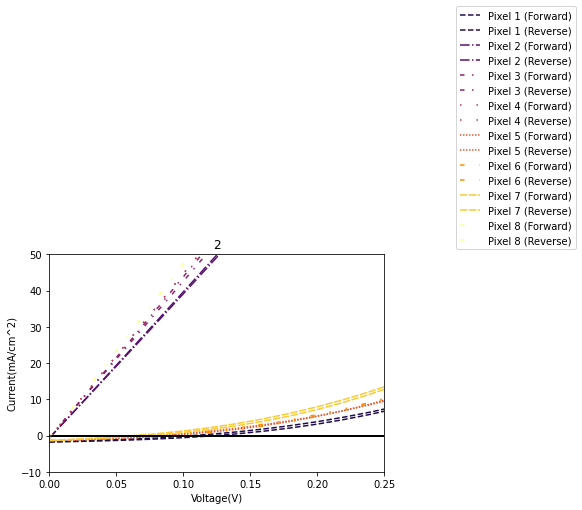

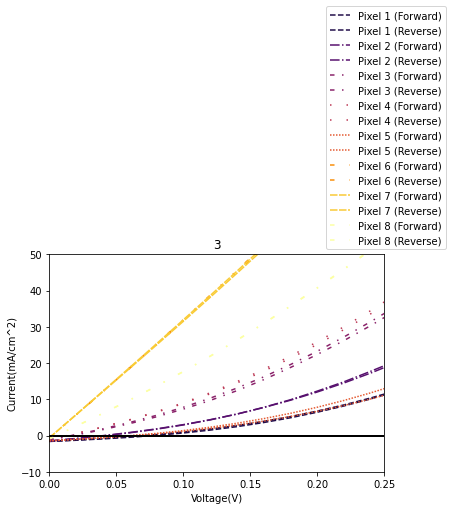

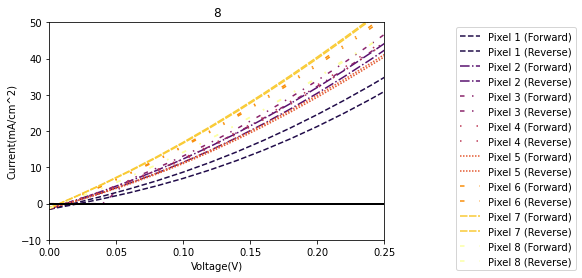

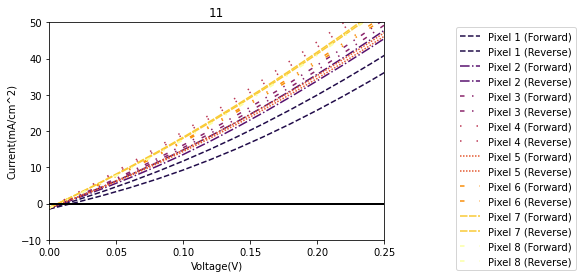

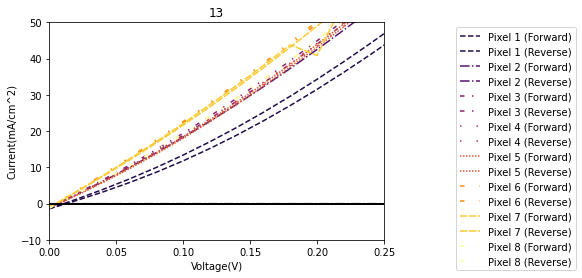

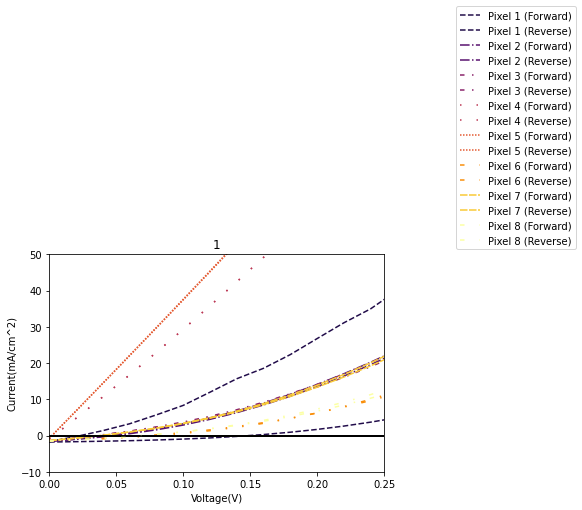

In [66]:
def plot_JVs(input_data):
  x = np.asarray(input_data.index)
  for j in sorted(input_data.columns):
    y=np.asarray(input_data[j])
    pixn=int(j[6])
    plt.plot(x, y, label = j, color=colormap(pixn/8), linestyle=styles[pixn])
    plt.axhline(y=0, color='k')

colormap = cm.get_cmap('inferno')
styles = [':', '--', '-.', (0, (3, 5, 1, 5)), (0, (1, 10)), (0, (1, 1)), (0, (3, 10, 1, 10, 1, 10)), (0, (5, 1)), (0, (3, 10, 1, 10)), (0, (5, 5)),(0, (3, 1, 1, 1)),  (0, (1, 1))]

for name in AV_li:
  plot_JVs(data_split(AV_li[name]))
  plt.title(name)
  plt.xlabel("Voltage(V)")
  plt.ylabel("Current(mA/cm^2)")
  plt.xlim(0, 0.25)
  plt.ylim(-10, 50)
  plt.legend(bbox_to_anchor=(1.2,1))
  plt.show()

In [20]:
def get_vals(input_data, num):
  x=np.asarray(input_data.index)
  y=np.asarray(input_data[input_data.columns[num]])
  #creates spline cubic interpolation function
  f = interp1d(x, y, 'cubic')
  #get zeroes from interpolation 
  Jsc = float(f(0))
 
  if len(scipy.interpolate.InterpolatedUnivariateSpline(x, y).roots()) == 0:
    Voc = np.nan
  else:
     Voc = scipy.interpolate.InterpolatedUnivariateSpline(x, y).roots().astype(float)[0]
  #plot x*y vs x to get P vs V
  PvsVdata = pd.DataFrame(np.stack((x, x*y), axis =-1), columns=('Voltage(V)', 'Power(W)'))
  #other relevant quantities
  Pmax = min(PvsVdata['Power(W)'])
  FF = Pmax /(Jsc*Voc)
  #Irradiance from spectral data
  Ispec = 99.1
  PCE = -Pmax / (Ispec) * 100
  return {'Test':str(name), 'Pixel': input_data.columns[num], 'Jsc (mA/cm^2)':Jsc, 'Voc (V)':Voc, 'Pmax (mW/cm^2)':Pmax, 'FF':FF , 'PCE(%)':PCE}


In [32]:
#Assemble data
df = pd.DataFrame(columns = ['Test','Pixel', 'Jsc (mA/cm^2)', 'Voc (V)', 'Pmax (mW/cm^2)', 'FF', 'PCE(%)'])
nf = pd.DataFrame(columns = ['Test', 'Pixel', 'Reason'])

for name in split_li:
  for i in range(len(split_li[name].columns)):
    df = df.append(get_vals(split_li[name], i), ignore_index =True)
#came back later to create dataframe for values left out to create table
#stats
to_remove = []
for i in range(len(df.index)):
  if df.iloc[i]['PCE(%)'] == 0:
    nf = nf.append({'Test': df.iloc[i]['Test'], 'Pixel': df.iloc[i]['Pixel'], 'Reason': 'PCE = ' + str(np.around(df.iloc[i]['PCE(%)'], decimals=2))+'%'}, ignore_index=True)
    to_remove.append(i)
  elif df.iloc[i]['FF'] >= 1:
    nf = nf.append({'Test': df.iloc[i]['Test'], 'Pixel': df.iloc[i]['Pixel'], 'Reason': 'Fill Factor = ' + str(np.around(df.iloc[i]['FF'], decimals=2))}, ignore_index=True)
    to_remove.append(i)
  elif pd.isna(df.iloc[i]['Voc (V)']):
    nf = nf.append({'Test': df.iloc[i]['Test'], 'Pixel': df.iloc[i]['Pixel'], 'Reason': 'Unstable Voc'}, ignore_index=True)
    to_remove.append(i)
nf = nf.set_index('Test')
df = df.drop(labels=to_remove, axis=0)
print(nf.to_string())
print(to_remove)
print(df.to_string())


                  Pixel                 Reason
Test                                          
2     Pixel 2 (Forward)             PCE = 0.0%
2     Pixel 3 (Forward)             PCE = 0.0%
2     Pixel 4 (Forward)             PCE = 0.0%
2     Pixel 8 (Forward)             PCE = 0.0%
2     Pixel 2 (Reverse)             PCE = 0.0%
2     Pixel 3 (Reverse)             PCE = 0.0%
2     Pixel 4 (Reverse)             PCE = 0.0%
2     Pixel 8 (Reverse)             PCE = 0.0%
3     Pixel 3 (Forward)             PCE = 0.0%
3     Pixel 4 (Forward)             PCE = 0.0%
3     Pixel 6 (Forward)             PCE = 0.0%
3     Pixel 7 (Forward)             PCE = 0.0%
3     Pixel 8 (Forward)             PCE = 0.0%
3     Pixel 3 (Reverse)             PCE = 0.0%
3     Pixel 4 (Reverse)             PCE = 0.0%
3     Pixel 6 (Reverse)             PCE = 0.0%
3     Pixel 7 (Reverse)             PCE = 0.0%
3     Pixel 8 (Reverse)             PCE = 0.0%
8     Pixel 2 (Forward)             PCE = 0.0%
8     Pixel 3

In [34]:
#creating dataframes to support overall conclusions per group

groups = ['1', '2', '3']
quantities = df.columns[2:]
summary = pd.DataFrame(columns=quantities, index=groups)
for group in groups:
  for quantity in quantities:
    qmean = np.around(df[df.Test.str.contains(group,case=False)][quantity].mean(), 2)
    qdev = np.around(df[df.Test.str.contains(group,case=False)][quantity].std(), 2)
    qstr = "    " + str(qmean) + ' (+/- ' + str(qdev) + ")    "
    summary.loc[group, quantity] = qstr

summary







,Jsc (mA/cm^2),Voc (V),Pmax (mW/cm^2),FF,PCE(%)
1,-1.53 (+/- 0.11),0.06 (+/- 0.03),-0.03 (+/- 0.02),0.27 (+/- 0.05),0.03 (+/- 0.02)
2,-1.48 (+/- 0.17),0.09 (+/- 0.02),-0.04 (+/- 0.02),0.31 (+/- 0.02),0.04 (+/- 0.02)
3,-1.52 (+/- 0.08),0.06 (+/- 0.02),-0.02 (+/- 0.01),0.27 (+/- 0.01),0.03 (+/- 0.01)


Need new routine for removing dead cells

[array([0.0989885 , 0.0213336 , 0.01339754, 0.03566987, 0.01450688,
       0.03191516, 0.00546141, 0.01945629, 0.01348287, 0.0310618 ,
       0.01433621, 0.02952577]), array([0.07680113, 0.03993657, 0.04121661, 0.02986712, 0.06067265,
       0.03532852, 0.03362184, 0.02355237]), array([0.03720589, 0.01715225, 0.02355237, 0.03225647, 0.01595758,
       0.02423504])]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


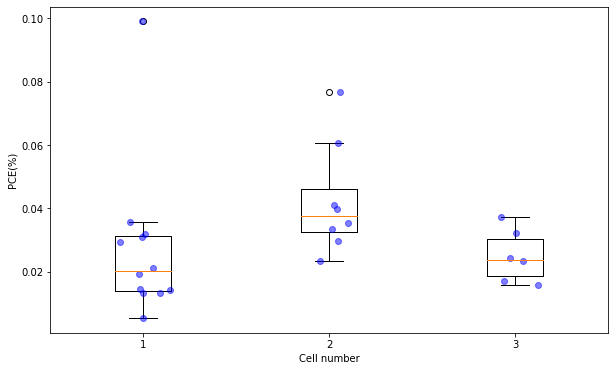

In [39]:
#Assigning groups to data for boxplot
one = np.asarray(df[df.Test.str.contains('1',case=False)]['PCE(%)'])
two = np.asarray(df[df.Test.str.contains('2',case=False)]['PCE(%)'])
three = np.asarray(df[df.Test.str.contains('3',case=False)]['PCE(%)'])

data = [one, two, three]
print(data)
plt.figure(figsize=[10,6])
plt.boxplot(data)
plt.xticks(np.arange(1,4), ('1', '2', '3'))
plt.ylabel('PCE(%)')
plt.xlabel('Cell number')
names = ['1', '2', '3']
#Method from https://stackoverflow.com/questions/29779079/adding-a-scatter-of-points-to-a-boxplot-using-matplotlib, slightly revised
for i in range(1,4):
    y = df[df.Test.str.contains(names[i-1], case=False)]['PCE(%)']
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i, 0.06, size=len(y))
    plt.plot(x, y, 'bo', alpha=0.5)

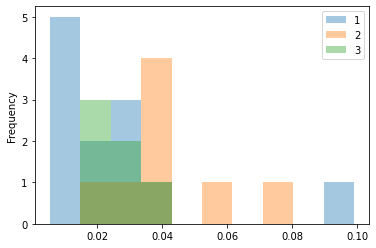

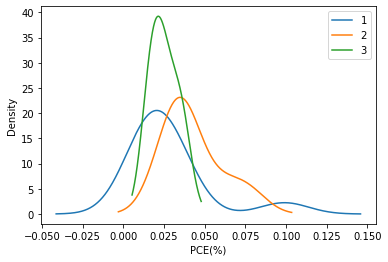

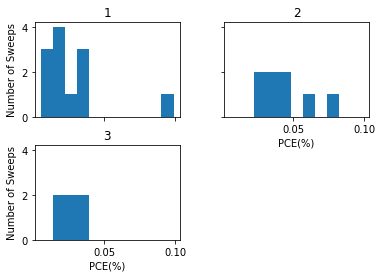

In [40]:
pcestr = pd.DataFrame([one, two, three])
pces = pcestr.transpose()
pces = pces.set_axis(['1', '2', '3'], axis = 1, inplace = False)
pces.plot.hist(bins=10, alpha = 0.4)
pces.plot(kind='kde')
plt.xlabel('PCE(%)')
bins=np.histogram(np.hstack((one, two, three)), bins=11)[1]
axarr = pces.hist(bins=bins, sharex=True, sharey=True)
for ax in axarr.flatten():
    ax.set_xlabel("PCE(%)")
    ax.set_ylabel("Number of Sweeps")
    ax.grid(False)


In [43]:
pcedf = pd.DataFrame({'1':one, '2':two, '3':three})
pcedf
#Look at each quantity in our data for any outliers
for i in range(4):  
  df.pivot(index='Test', columns='Pixel', values=list(df)[i+2]).plot(kind='bar', ylabel=list(df)[i+2])

ValueError: ignored

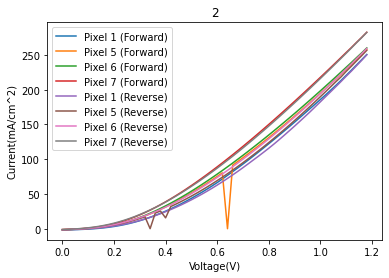

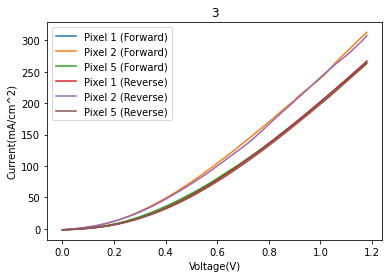

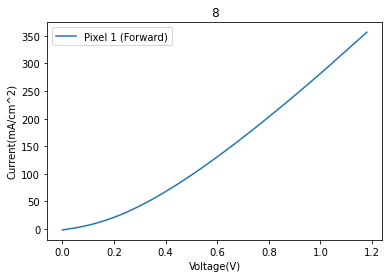

No handles with labels found to put in legend.


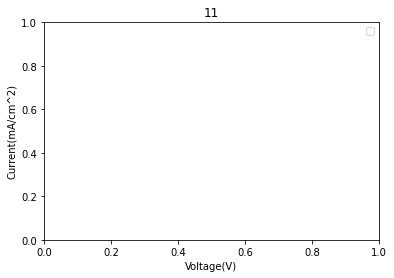

No handles with labels found to put in legend.


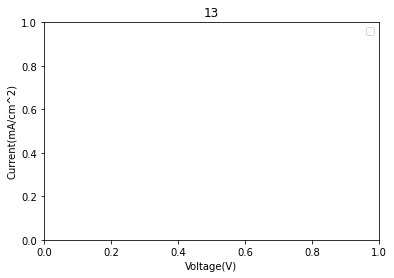

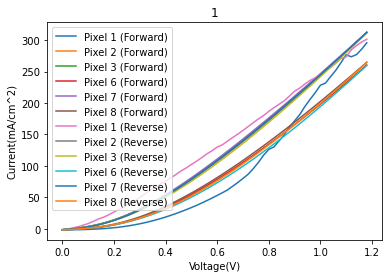

In [45]:
#check what new JV curves look like
for name in AV_li:
  keep_cols = []
  for pixel in df[df['Test']==str(name)]['Pixel']:
    keep_cols.append(pixel)
  plot_JVs(data_split(AV_li[name])[keep_cols])
  plt.title(name)
  plt.xlabel("Voltage(V)")
  plt.ylabel("Current(mA/cm^2)")
  plt.legend()
  plt.show()